In [13]:
# Imports
import gymnasium as gym
import random
from environments.grid_world import GridWorldEnv
import matplotlib.pyplot as plt
import numpy as np

In [3]:
### Deterministic CliffWalking-v1
gym.register(
    id="gymnasium_env/GridWorld-v2",
    entry_point=GridWorldEnv,
    max_episode_steps=300,  # Prevent infinite episodes
)
gym.pprint_registry()

===== classic_control =====
Acrobot-v1             CartPole-v0            CartPole-v1
MountainCar-v0         MountainCarContinuous-v0 Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0     phys2d/CartPole-v1     phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3       BipedalWalkerHardcore-v3 CarRacing-v3
LunarLander-v3         LunarLanderContinuous-v3
===== toy_text =====
Blackjack-v1           CliffWalking-v1        CliffWalkingSlippery-v1
FrozenLake-v1          FrozenLake8x8-v1       Taxi-v3
===== tabular =====
tabular/Blackjack-v0   tabular/CliffWalking-v0
===== None =====
Ant-v2                 Ant-v3                 GymV21Environment-v0
GymV26Environment-v0   HalfCheetah-v2         HalfCheetah-v3
Hopper-v2              Hopper-v3              Humanoid-v2
Humanoid-v3            HumanoidStandup-v2     InvertedDoublePendulum-v2
InvertedPendulum-v2    Pusher-v2              Reacher-v2
Swimmer-v2             Swimmer-v3             Walker2d-v2
Walker2d-v3
===== mujoco =====
Ant-v4    

In [4]:
# Environment
env = gym.make("gymnasium_env/GridWorld-v2", render_mode='rgb_array')
env.reset()
num_states = env.observation_space.n
num_actions = env.action_space.n

In [27]:
# Policy Iteration Class
class PolicyIteration:
    def __init__(self, env, num_states, num_actions, gamma=0.99, theta=1e-6):
        self.env = env
        self.num_states = num_states
        self.num_actions = num_actions
        self.policy = {state: random.randint(0, self.num_actions-1) for state in range(self.num_states)}
        self.terminal_state = num_states-1
        self.gamma = gamma
        self.theta = theta

    def compute_state_value(self, state, V):
        action = self.policy[state]
        _, next_state, reward, done = self.env.unwrapped.P[state][action][0]
        value = reward + self.gamma * V[next_state] * (not done)
        return value

    def compute_action_value(self, state, action, V):
        _, next_state, reward, done = self.env.unwrapped.P[state][action][0]
        value = reward + self.gamma * V[next_state] * (not done)
        return value

    def policy_evaluation(self):
        V = {state: 0 for state in range(self.num_states)}
        while True:
            delta = 0
            for state in range(self.num_states):
                old_value = V[state]
                V[state] = self.compute_state_value(state, V)
                delta = max(delta, abs(old_value - V[state]))
            if delta < self.theta:
                break
        return V

    def policy_improvement(self, V):
        is_policy_stable = True

        Q = {(state, action): 0 for state in range(self.num_states) for action in range(self.num_actions)} # Generate the Q-value dictionary

        for state in range(self.num_states):
            old_action = self.policy[state]
            for action in range(self.num_actions):
                Q[(state, action)] = self.compute_action_value(state, action, V)
            # Get the action with best Q-value for a state across all its actions
            max_action = max(range(self.num_actions), key=lambda action: Q[(state, action)])
            self.policy[state] = max_action

            if old_action != max_action:
                is_policy_stable = False

        return is_policy_stable, Q

    def policy_iteration(self):
        while True:
            V = self.policy_evaluation()
            is_policy_stable, Q = self.policy_improvement(V)

            if is_policy_stable:
                break

        return self.policy, V, Q


In [28]:
PI = PolicyIteration(env, num_states, num_actions, gamma=.5)
policy, V, Q = PI.policy_iteration()

In [29]:
# Actions are represented as: (3 → left, 2 → down, 1 → right, 0 → up).
policy

{0: 1, 1: 1, 2: 2, 3: 1, 4: 1, 5: 2, 6: 1, 7: 1, 8: 0}

In [30]:
V

{0: -0.5, 1: 1.0, 2: 4.0, 3: 1.0, 4: 4.0, 5: 10.0, 6: 4.0, 7: 10.0, 8: 0.0}

In [31]:
Q

{(0, 0): -1.25,
 (0, 1): -0.5,
 (0, 2): -0.5,
 (0, 3): -1.25,
 (1, 0): -0.5,
 (1, 1): 1.0,
 (1, 2): 1.0,
 (1, 3): -1.25,
 (2, 0): 1.0,
 (2, 1): 1.0,
 (2, 2): 4.0,
 (2, 3): -0.5,
 (3, 0): -1.25,
 (3, 1): 1.0,
 (3, 2): 1.0,
 (3, 3): -0.5,
 (4, 0): -0.5,
 (4, 1): 4.0,
 (4, 2): 4.0,
 (4, 3): -0.5,
 (5, 0): 1.0,
 (5, 1): 4.0,
 (5, 2): 10.0,
 (5, 3): 1.0,
 (6, 0): -0.5,
 (6, 1): 4.0,
 (6, 2): 1.0,
 (6, 3): 1.0,
 (7, 0): 1.0,
 (7, 1): 10.0,
 (7, 2): 4.0,
 (7, 3): 1.0,
 (8, 0): 0.0,
 (8, 1): 0.0,
 (8, 2): 0.0,
 (8, 3): 0.0}

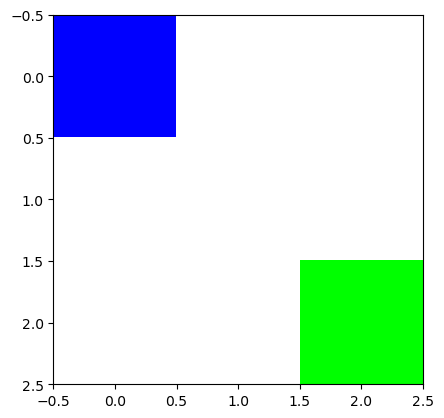

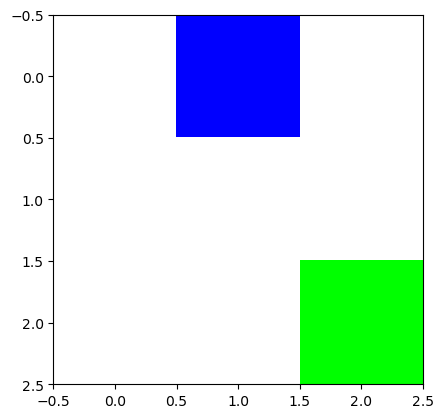

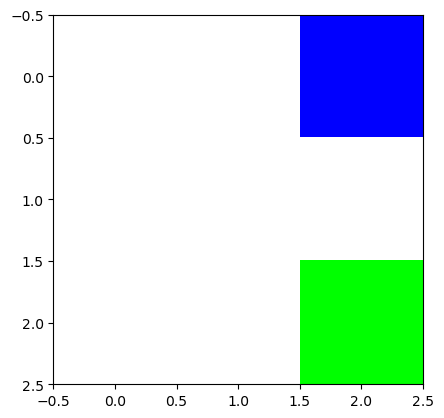

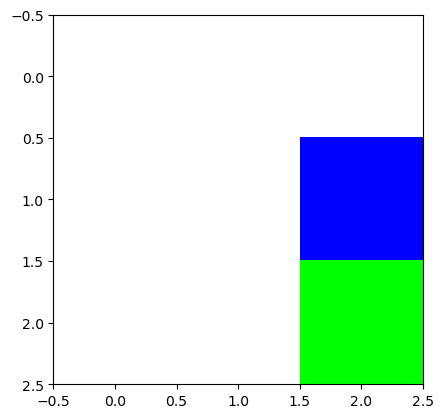

<Figure size 640x480 with 0 Axes>

In [32]:
# Visualise the policy
def simulate_policy(env, policy, pause=0.5):
    state, _ = env.reset()

    done = False
    while not done:
        # Render
        img = env.render()
        if img is not None:
            plt.imshow(img)
            plt.axis('on')
            plt.show(block=False)
            plt.pause(pause)
            plt.clf()

        # Take action from policy
        action = policy[state]
        state, reward, done, _, _ = env.step(action)

simulate_policy(env, policy, pause=0.7)

In [40]:
# Visualise the Value Function
def visualize_value_function(V, agent_name="PI", env_size=3):
    """
    Display the state values as a heatmap.
    """
    plt.figure(figsize=(8, 6))
    
    # Populate the value grid with state values
    value_grid = np.array(list(V.values())).reshape(env_size, env_size)
    
    # Create the heatmap visualization
    plt.imshow(value_grid, cmap='viridis')
    plt.colorbar(label='State Value')
    plt.title('Learned State Values')
    
    # Add value text in each cell for precision
    for row in range(env_size):
        for col in range(env_size):
            value = value_grid[row, col]
            text_color = "white" if value < 0.5 * np.max(value_grid) else "black"
            plt.text(col, row, f"{value:.2f}",
                     ha="center", va="center", color=text_color)
    plt.show()
    plt.savefig(f"visualisations/{agent_name}_value_function.png")
    plt.close()
    print("Value function visualisation saved")

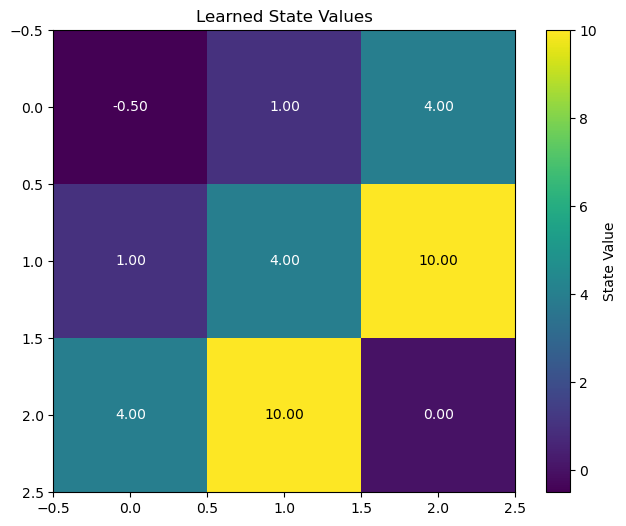

Value function visualisation saved


In [39]:
visualize_value_function(V)